# 量子機械学習：解答例

Kifumi Numata, IBM Quantum (Jan 20, 2025)

Google Colab で行う場合は、次のセルの「#」を削除して実行します。

In [1]:
#!pip install qiskit qiskit-ibm-runtime qiskit-aer qiskit[visualization]
#!pip install -U scikit-learn

qBraid で行う場合は、右上の「Python 3[Default]」をクリックして「Python 3[QDC24]」を選択し、次のセルの「#」を削除して実行したあと、上部の「Kernel」→「Restart Kernel...」からカーネルをリスタートしてください。

In [1]:
#!pip install pylatexenc
#!pip install -U scikit-learn

In [2]:
import qiskit
qiskit.__version__

'1.3.0'

### 目次:
1. カーネル行列の要素
2. 完全なカーネル行列
3. 演習： 手書き文字の分類

## 1. カーネル行列の要素

### Step 1: 古典の入力を量子の問題にマッピングする


まず、数個の特徴量（例えば4個）を持つデータセットを考えてみましょう。カーネル行列の要素を計算するために少なくとも2つのデータポイントが必要なので、まずそこから始め、必要なパッケージをいくつかインポートします：

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ラベルを含む学習用の2つのデータポイント
small_data = [[-0.194,0.114,-0.006,0.301,1],[-0.1,0.002,0.244,0.127,-1]]

# 内積計算のためにラベルを除去したデータ点
train_data = [small_data[0][:-1],small_data[1][:-1]]

### 符号化

このデータを量子特徴量マップを使って量子状態に符号化(エンコード)します。`ZZFeatureMap`を試してみます。4量子ビットの場合、ZZFeaturemapの回路は以下のようになります。

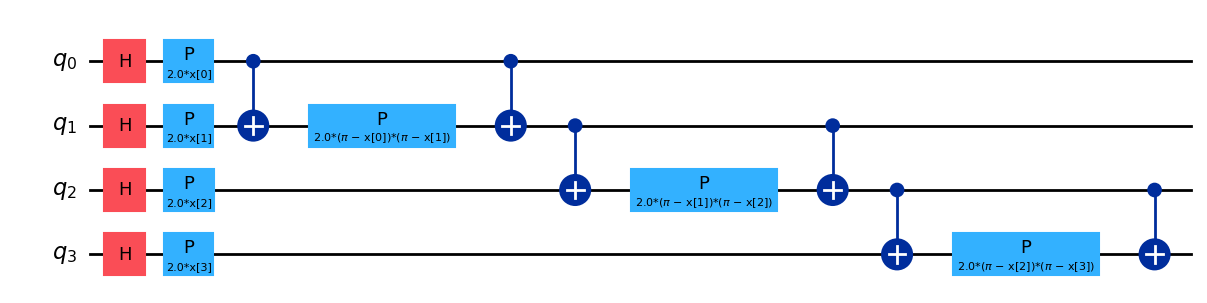

In [4]:
from qiskit.circuit.library import ZZFeatureMap

zz_fm = ZZFeatureMap(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

zz_fm.decompose().draw("mpl", fold=-1)

上記で用意した `train_data` を、ZZFeatureMapを使って量子状態にマッピングします。

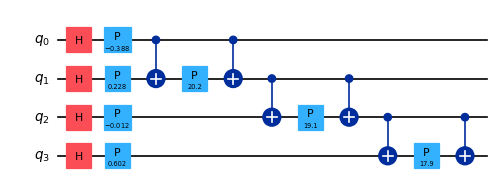

In [5]:
unitary1 = zz_fm.assign_parameters(train_data[0])
unitary2 = zz_fm.assign_parameters(train_data[1])

unitary1.decompose().draw("mpl", scale=0.6, fold=-1)

次に、 `UnitaryOverlap` を使用して量子カーネル行列の1つの要素を計算する量子回路を作成します。また、回路のDepthを確認します。

circuit depth =  23


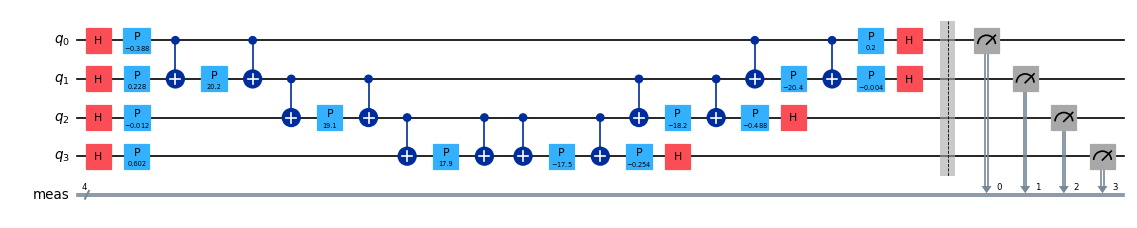

In [6]:
from qiskit.circuit.library import UnitaryOverlap
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, fold=-1)

回路が左右対称であることがわかります。左半分に学習データ `train_data[0]` 、右半分に学習データ `train_data[1]` がエンコードされています。

### Step 2:  量子実行のための問題の最適化

Aer Simulatorをバックエンドとして使い、上記の回路を最適化します。今回は、実機のバックエンドを使用しませんが、sampler が ZZFeatureMap を認識できないため、回路をトランスパイルする必要があります。

In [7]:
# シミュレーターを使います
from qiskit_aer import AerSimulator
backend = AerSimulator()

# 回路を最適化します
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
overlap_ibm = pm.run(overlap_circ)

### Step 3: Qiskit Runtime Primitivesを使って実行する

Qiskit Runtime Primitivesを使って回路を実行します。

In [8]:
# シミュレーターを使います
from qiskit_ibm_runtime import Sampler
num_shots = 10000
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
counts_bit = results[0].data.meas.get_counts()
counts = results[0].data.meas.get_int_counts()

print(counts_bit)

{'0110': 1497, '0000': 6963, '0100': 528, '1000': 216, '0010': 172, '0001': 86, '1010': 95, '0011': 54, '1110': 89, '1100': 290, '1001': 3, '1101': 4, '0111': 2, '1111': 1}


### Step 4: 後処理を行い、古典の形式で結果を返す

ここで最も有用となる測定は、ゼロの状態 $|0000\rangle$ を測定する確率です。

In [9]:
counts.get(0, 0.0)/num_shots

0.6963

カーネル行列の要素の1つをこれで計算できました。次に、カーネル行列のすべての要素を計算します。

## 2. 完全なカーネル行列

このセクションでは、上記のプロセスを完全なデータセットの2値分類に拡張します。ここでの特徴量マップは、Qiskitの組み込みfeature mapを使わずに、自作します。完全なカーネル行列を作ったあと、古典の機械学習を実装し、学習精度のスコアを求めます。

### Step 1: 古典の入力を量子の問題にマッピングする
ここで、分類のために既存のデータセットをインポートします。このデータセットは128行（データポイント）と各ポイントにおける14個の特徴量からなります。また、各ポイントにはバイナリーのカテゴリー ($\pm 1$) を示す15番目の要素があります。データセットは以下でインポートされます。また、[ここ](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/data/dataset_graph7.csv)からデータセットにアクセスしてその構造を見ることもできます。

128のデータポイントのうち、最初の60データポイントを学習に使い、次の20ポイントをテストに使います。

In [10]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)

# 学習データの準備
train_size = 60
X_train=df.values[0:train_size,:-1]
train_labels = df.values[0:train_size,-1]

# テストデータの準備
test_size = 20
X_test=df.values[train_size:train_size+test_size,:-1]
test_labels=df.values[train_size:train_size+test_size,-1]

--2025-01-20 11:06:00--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443 に接続しています... 接続しました。
200 OKよる接続要求を送信しました、応答を待っています... 
長さ: 49405 (48K) [text/plain]
`dataset_graph7.csv.1' に保存中

dataset_graph7.csv. 100%[===================>]  48.25K  --.-KB/s 時間 0.01s      

2025-01-20 11:06:01 (3.61 MB/s) - `dataset_graph7.csv.1' へ保存完了 [49405/49405]



出力を格納するために、空のカーネル行列と、適切な次元の空のテスト用カーネル行列を作ります。

In [11]:
# 空のカーネル行列
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan) # 60x60の学習用カーネル行列
test_matrix = np.full((test_size, num_samples), np.nan) # 20x60のテスト用カーネル行列

次に、古典データを量子回路に符号化するための特徴量マップを自作します。

In [12]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit

# overlapを計算するための特徴量の準備
num_features = np.shape(X_train)[1] #14
num_qubits = int(num_features / 2) #7

# カスタムのfeature mapでは、以下の行をエンタングルメントさせます
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]

fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits) # pi/2回転なのでHゲートと等価
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

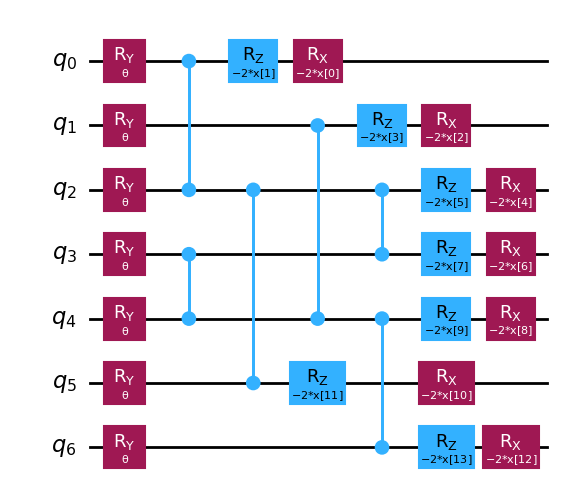

In [13]:
fm.draw("mpl") # 各qubitに2つのデータをエンコードするため7qubit回路

### Step 2 & 3: 問題を最適化し、primitiveを使って実行する

Overlap回路を作ります。カーネル行列は対角に対して対称なので、同じ計算は繰り返さないようにすることで、計算回数は二分の一に減らせます。また、ノイズがない場合は対角要素が1となるため、今回は対角要素を計算せず、1を代入します。(60×60×1/2-60)要素と(20×60)要素の合計2920要素を計算するので、以下のセルは実行にすこし時間がかかります。

In [14]:
num_shots = 1000

backend = AerSimulator()
sampler = Sampler(mode=backend)


for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Overlap回路の作成
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        # Qiskit sampler primitiveの実行
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        # |0>状態の確率をカーネル行列の要素に入れ、転置された要素にも同じ確率を入れます。
        kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0)/num_shots
    # 確率の内積なので、対角線上の要素を1で埋めます
    kernel_matrix[x1,x1] =1    

print("training done")

# 上記と同様のプロセスをテストデータを使って行う
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])

        # Overlap回路の作成
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()
    
        counts = (
            sampler.run([overlap_circ], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done


2つのカーネル行列を見てみましょう。

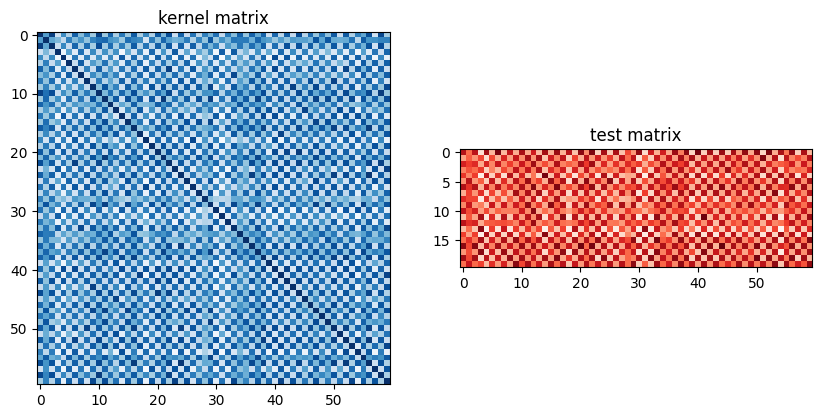

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("test matrix")
plt.show()

### Step 4: 後処理を行い、古典の形式で結果を返す

量子カーネル法からカーネル行列と同様の形式の test_matrix が得られたので、古典の機械学習アルゴリズムを適用してテストデータの予測を行い、その精度をチェックすることができます。まず、Scikit-Learnの`sklearn.svc`、サポートベクトル分類器（SVC）をインポートします。SVC に事前に計算したカーネルを使わせたい場合は、`kernel = precomputed` を使って指定します。

In [16]:
# 古典の機械学習パッケージからサポートベクトル分類器をインポート
from sklearn.svm import SVC

# 事前に計算されたカーネル行列を使用することを指定
qml_svc = SVC(kernel="precomputed")

`SVC.fit` を使って、カーネル行列と学習用ラベルを入力し、fitを得ることができます。`SVC.predict` は test_matrix を使ってテストデータのラベルを予測します。`SVC.score` はテストデータをスコアリングして精度を返します。

In [17]:
# 事前に計算された行列と学習データのラベルを入力。古典アルゴリズムがfitを行います。
qml_svc.fit(kernel_matrix, train_labels)

# 学習データとテストデータのカーネル行列を用いてテストデータのラベルを予測します。
label_predict = qml_svc.predict(test_matrix)
print(label_predict, test_labels, sep="\n")

# テストデータの行列とテストラベルを入力として、.scoreを使ってデータをテストします。
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
[ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1. -1.]
Precomputed kernel classification test score: 1.0


学習したモデルの精度は100%でした。これは素晴らしいことで、QKE(Quantum Kernel Estimation)が機能することを示しています。しかし、これは量子の優位性ではありません。古典カーネルでも、おそらくこの分類問題を100%の精度で解くことができるでしょう。現在のユーティリティ時代に量子カーネルが最も役立つのはどこなのか、さまざまなデータタイプやデータ関係を特徴づけるためにやるべきことはたくさんあります。量子特徴量マップを変更してその有効性を研究してみてください。

## 3. 演習: 手書き文字の分類

次に、手書き数字画像データセット（MNISTデータセット）から`0`と`1`の部分集合を扱い、QKEを実行してみます。

In [18]:
# Scikit-learnのインポート
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

### Step 1: 古典の入力を量子の問題にマッピングする

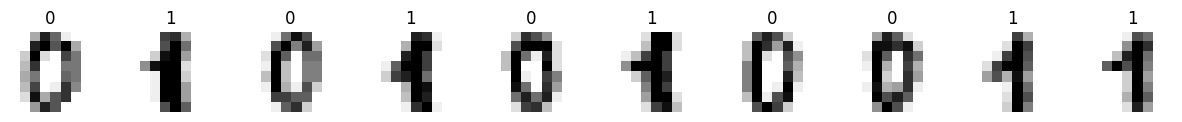

In [19]:
# 数値データセットから2つのクラス（0と1）のデータをロードする
digits = datasets.load_digits(n_class=2)   

# ロードした最初の10個の画像をプロット
fig, axes = plt.subplots(1, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

以下のデータ配列に`0` が見えるかもしれません。0は白、16が黒に対応しています。

In [20]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


このデータセットには、合計360個のデータが含まれています。各データポイントは、8×8の数字の画像で、配列になっていて、各要素は0（白）から16（黒）までの整数です。古典的な分類アルゴリズムの際と同様に、データセットを学習用（25個）とテスト用（10個）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類アルゴリズムに用いるために、範囲を-1から1の間にスケーリングし、次元を使用する量子ビット数（今回は4）に縮小します。

In [21]:
# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.4, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 学習用25個とテスト用10個を選択
train_size = 25
X_train = sample_train[:train_size]
train_labels = labels_train[:train_size]

test_size = 10
X_test = sample_test[:test_size]
test_labels = labels_test[:test_size]

In [22]:
# 一つ目のデータを表示
print(X_test[0])

[0.41456664 0.7486731  0.74168091 0.32496914]


### 演習 1: 

ZZFeamtureMapを使って特徴量マップの回路を作ってください。(ZZFeaturemapはこのNotebookの最初で使っています。)

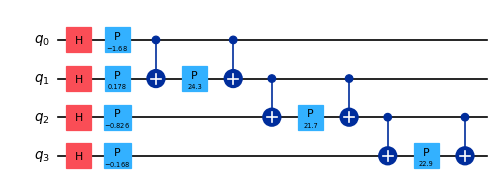

In [23]:
from qiskit.circuit.library import ZFeatureMap
#fm = ??? # 特徴量マップの回路を作ってください。
fm =ZZFeatureMap(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)

unitary1 = fm.assign_parameters(X_train[0]) # Featuremap次第では更新が必要かもしれません
unitary2 = fm.assign_parameters(X_train[1]) # Featuremap次第では更新が必要かもしれません

unitary1.decompose().draw("mpl", scale=0.6, fold=-1)

circuit depth =  23


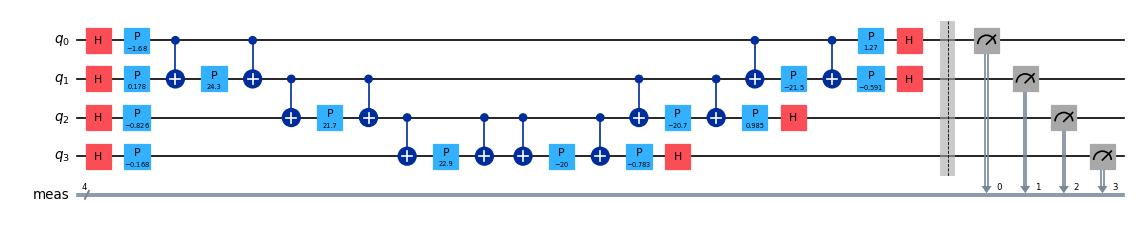

In [24]:
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, fold=-1)

In [25]:
# 空のカーネル行列の作成
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan) # Matrix of 40x40
test_matrix = np.full((test_size, num_samples), np.nan) # Matrix of 10x40

### Step 2 & 3: 問題を最適化し、primitiveを使って実行する

### 演習 2: 

UnitaryOverlapを計算するために必要な、unitary1とunitary2の回路のパラメーターにデータをアサインしてください。上の演習で作った、featuremapを使います。

In [26]:
num_shots = 1000

backend = AerSimulator()
sampler = Sampler(mode=backend)


for x1 in range(0,train_size):
    for x2 in range(x1+1,train_size):
        #unitary1 = ?? # fmのパラメーターにデータをアサインしてください
        #unitary2 = ?? # fmのパラメーターにデータをアサインしてください
        unitary1 = fm.assign_parameters(list(X_train[x1])) # Featuremap次第では更新が必要かもしれません
        unitary2 = fm.assign_parameters(list(X_train[x2])) # Featuremap次第では更新が必要かもしれません
        
        # Overlap回路の作成
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # 回路の最適化
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
        overlap_ibm = pm.run(overlap_circ)
    
        # Qiskit sampler primitiveの実行
        counts = (
            sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

         # |0>状態の確率をカーネル行列の要素に入れ、転置された要素にも同じ確率を入れます。
        kernel_matrix[x1, x2] = counts.get(0, 0.0)/num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0)/num_shots
    # 確率の内積なので、対角線上の要素を1で埋めます
    kernel_matrix[x1,x1] =1    

print("training done")

# 上記と同様のプロセスをテストデータを使って行う
for x1 in range(0,test_size):
    for x2 in range(0,train_size):
        #unitary1 = ?? # fmのパラメーターにデータをアサインしてください
        #unitary2 = ?? # fmのパラメーターにデータをアサインしてください        
        unitary1 = fm.assign_parameters(list(X_test[x1])) # Featuremap次第では更新が必要かもしれません
        unitary2 = fm.assign_parameters(list(X_train[x2])) # Featuremap次第では更新が必要かもしれません
        
        # Overlap回路の作成
        overlap_circ = UnitaryOverlap(unitary1, unitary2)
        overlap_circ.measure_all()

        # 回路の最適化
        pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
        overlap_ibm = pm.run(overlap_circ)
    
        counts = (
            sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
        )

        test_matrix[x1, x2] = counts.get(0, 0.0)/num_shots

print("test matrix done")

training done
test matrix done


kernel_matrixとtest_matrixを見てみましょう。

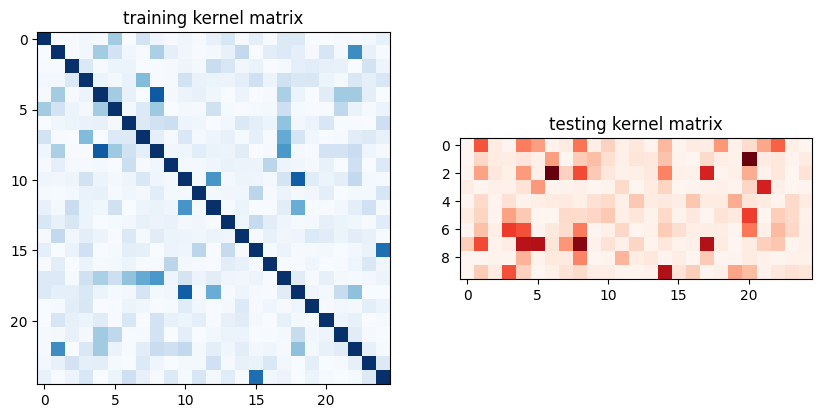

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(kernel_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

### Step 4: 後処理を行い、古典の形式で結果を返す

古典機械学習のアルゴリズムを適用して、テストデータの予測を行い、その精度をチェックします。

In [28]:
# 事前に計算されたカーネル行列を使用することを指定
qml_svc = SVC(kernel="precomputed")

# 事前に計算された行列と学習データのラベルを入力。古典アルゴリズムがfitを行います。
qml_svc.fit(kernel_matrix, train_labels)

# 学習データとテストデータのカーネル行列を用いてテストデータのラベルを予測します。
label_predict = qml_svc.predict(test_matrix)
print(label_predict, test_labels, sep="\n")

# テストデータの行列とテストラベルを入力として、.scoreを使ってデータをテストします。
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

[0 1 0 1 1 1 0 0 1 0]
[1 1 0 1 1 1 0 0 1 0]
Precomputed kernel classification test score: 0.9


スコアはどうでしたか？もし時間があれば、他のfeaturemapも試してみてください。

## 参考：実機で実行する場合 (無料枠を使い切ってしまうので実行しないでください)

実機で実行するには、バックエンドに実機を指定して、実機に合わせてトランスパイルすると実行可能です。が、実験にとても時間がかかり、無料枠を使い切ってしまうので、実行しないでください。また、実行の前に、回路の深さを浅くする努力も必要です。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If this is your first time running your circuit on a real device, 
# make sure you copy your API Token from [IBM Quantum Platform](https://quantum.ibm.com/) 
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='<your_token>', overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")
service.backends()

In [ ]:
# You can specifiy the device 
backend = service.backend('ibm_sherbrooke')

In [ ]:
#You can also identify the least busy device
backend = service.least_busy(operational=True)
print("The least busy device is ", backend)